# In this script, I Experiment with the Cifar-10 dataset. Moreover, I will transfer the AANN modifications to conv-deconv autoencoder architecture.
-------------------------------------------------------------------------------------------------------------------
### Technology used: Tensorflow-core 

In [1]:
# packages used for machine learning
import tensorflow as tf

# packages used for processing: 
from six.moves import cPickle as pickle # for reading the data
import matplotlib.pyplot as plt # for visualization
import numpy as np
from sklearn.preprocessing import OneHotEncoder # for encoding the labels in one hot form

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '../..'])

Data
LICENSE
Literature_survey
Models
README.md
Res
Scripts



In [4]:
''' Set the constants for the script '''

# various paths of the files
data_path = "../../Data/cifar-10" # the data path
train_meta = os.path.join(data_path, "batches.meta")
idea = "IDEA_1"
base_model_path = '../../Models'
idea_model_path = os.path.join(base_model_path, idea)

# constant values:
size = 32 # the images of size 32 x 32
channels = 3 # RGB channels
highest_pixel_value = 255.0 # 8 bits for every channel. So, max value is 255
no_of_epochs = 500 # No. of epochs to run
no_of_batches = 5 # There are 5 batches in the dataset
checkpoint_factor = 5 # save the model after every 5 steps (epochs)
num_classes = 10 # There are 10 different classes in the dataset
k_size = 5 # all kernels are 5x5
n_hidden_neurons_in_fc_layers = 512
representation_vector_length = 128 # length of the mid_level representation vector
batch_size = 5000 # we look at 5000 images at a time

In [5]:
# check the contents inside the data folder
exec_command(['ls', data_path])

batches.meta
data_batch_1
data_batch_2
data_batch_3
data_batch_4
data_batch_5
readme.html
test_batch



In [6]:
# function to unPickle a file: 
def unpickle(file):
    '''
        This function takes the file path and unPickles the file acquired from it
        @Param file: the string path of the file
        @return: The dict object unPickled from the file
    '''
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

### Let's check the contents of the batches.meta file

In [7]:
meta_data = unpickle(train_meta)

# check it's contents
meta_data

{'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_cases_per_batch': 10000,
 'num_vis': 3072}

### Let's read and display some of the images from the dataset along with their labels

In [8]:
train_batch_preliminary = unpickle(os.path.join(data_path, "data_batch_3"))

# check it's contents
train_batch_preliminary.keys()

['data', 'labels', 'batch_label', 'filenames']

In [9]:
# Extract the first 3 images from the dataset
preliminary_data = train_batch_preliminary['data'].reshape((len(train_batch_preliminary['data']), 32, 32, 3), 
                                                           order='F')
preliminary_labels = train_batch_preliminary['labels']

# view some of the data:
preliminary_data[33, :10, :10, 2] #(10 x 10) data of blue channel of 33rd image

array([[178, 191, 193, 197, 202, 206, 207, 209, 214, 219],
       [140, 151, 155, 160, 166, 172, 173, 171, 176, 180],
       [ 84,  94, 119, 151, 146, 127, 125, 135, 139, 139],
       [ 16,  18,  85, 200, 207, 133,  71,  59,  72,  79],
       [  9,   3,  51, 183, 238, 219, 177,  94,  30,  16],
       [ 31,  25,  38, 148, 240, 249, 255, 235, 139,  39],
       [ 69,  65,  62, 115, 215, 250, 248, 253, 245, 201],
       [ 92,  89,  81,  89, 173, 240, 249, 253, 253, 255],
       [ 93,  90,  84,  85, 139, 217, 241, 246, 251, 252],
       [ 75,  74,  71,  87, 154, 208, 229, 239, 245, 250]], dtype=uint8)

In [10]:
# check a few values of the labels of the dataset
preliminary_labels[:10] 

[8, 5, 0, 6, 9, 2, 8, 3, 6, 2]

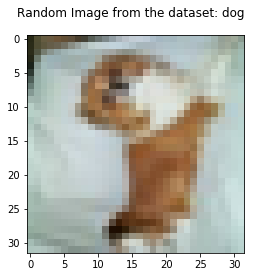

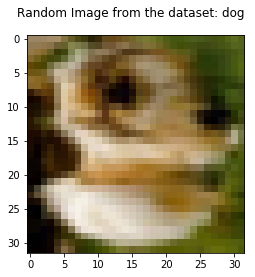

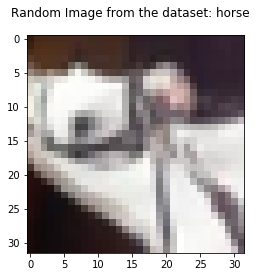

In [11]:
for _ in range(3):
    random_index = np.random.randint(preliminary_data.shape[0])
    
    plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
    plt.imshow(preliminary_data[random_index], interpolation='none')

### The images look blurred out because they are very low resolution images (32 x 32) pixels only.

## It can be seen that the images in the original dataset are skewed. So, we will have to rotate them by 90 degrees clockwise

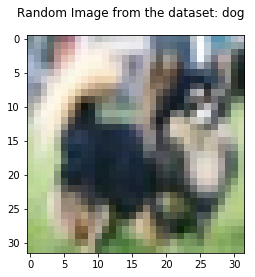

In [12]:
# let's try using the numpy.rot90 method for this:
random_index = np.random.randint(preliminary_data.shape[0])
    
plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
plt.imshow(np.rot90(preliminary_data[random_index], axes=(1, 0)), interpolation='none'); # suppress the unnecessary
# output

This works. So, now we can create a function to put all this together. This function would take the batch pickle file and create the data suitable for feeding it off to a convolutional neural network.

In [13]:
# The batch generator function:
def generateBatch(batchFile):
    '''
        The function to generate a batch of data suitable for performing the convNet operations on it
        @param batchFile -> the path of the input batchfile
        @return batch: (data, labels) -> the processed data.
    '''
    # unpickle the batch file:
    data_dict = unpickle(batchFile)
    
    # extract the data and labels from this dictionary
    unprocessed_data = data_dict['data']
    integer_labels = np.array(data_dict['labels']) # labels in integer form
    
    # reshape and rotate the data
    data = unprocessed_data.reshape((len(unprocessed_data), size, size, channels), order='F')
    processed_data = np.array(map(lambda x: np.rot90(x, axes=(1, 0)), data))
    
    # normalize the images by dividing all the pixels by 255
    processed_data = processed_data.astype(np.float32) / highest_pixel_value
    
    # encode the labels in one-hot encoded form
    # we use the sklearn.preprocessing package for doing this
    encoder = OneHotEncoder(sparse=False)
    encoded_labels = np.array(encoder.fit_transform(integer_labels.reshape(len(integer_labels), 1)))
    
    # return the processed data and the encoded_labels:
    return (processed_data, encoded_labels)

### Time to test this function

In [14]:
# load the batch no. 1 and check if it works correctly.
batch_data, batch_labels = generateBatch(os.path.join(data_path, "data_batch_1"))
print (batch_data.shape, batch_labels.shape)

# batch_data[0, :12, :12, 2]

((10000, 32, 32, 3), (10000, 10))


Random image shape: (32, 32, 3)
Random image dataTypefloat32


check if the data has been properly normalized
[[ 0.85882354  0.8509804   0.82352942]
 [ 0.84705883  0.84705883  0.81960785]
 [ 0.8392157   0.83529413  0.82352942]]


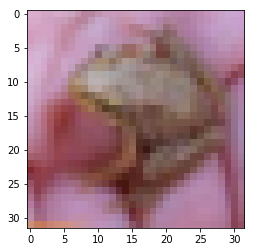

In [15]:
# extract one image from the data and display it
randomIndex = np.random.randint(batch_data.shape[0])
randomImage = batch_data[randomIndex]
print "Random image shape: " + str(randomImage.shape)

print "Random image dataType" + str(randomImage.dtype)

print "\n\ncheck if the data has been properly normalized"
print randomImage[:3, :3, 0]

# Visualize the random image from the dataset
plt.figure()
plt.imshow(randomImage, interpolation='none'); # suppress the unnecessary

Alright! So, the data extraction module is setup. Let's move on to the actual model building and training.

# Define the computation graph. This uses a conv-deconv network for the ANN concept

### define the placeholders for the computations:

In [16]:
# point to reset the graph:
tf.reset_default_graph()

In [17]:
with tf.variable_scope("Placeholders"):
    tf_input = tf.placeholder(tf.float32, shape=(None, size, size, channels), name="inputs")
    
    # add an image summary for the tf_input
    tf_input_summary = tf.summary.image("Input_images", tf_input)
    
    tf_labels = tf.placeholder(tf.float32, shape=(None, num_classes), name="labels")
    # this is to send in the representation vector tweaked by us to generate images that we want
    tf_representation_vector = tf.placeholder(tf.float32, shape=(None, num_classes), name="representation") 

In [18]:
# print all these tensors to check if they have been correctly defined
tf_input, tf_labels, tf_representation_vector
# all look good

(<tf.Tensor 'Placeholders/inputs:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'Placeholders/labels:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Placeholders/representation:0' shape=(?, 10) dtype=float32>)

### define the kernel and bias variables used for the computation. I am defining them separately instead of using the layers api from the latest tensorflow because I am going to use the same weights while deconvolving the representations (Use of tied weights).

In [19]:
with tf.variable_scope("Weights_and_biases"):
    # special b0 for the input images to be added when performing the backward computations
    b0 = tf.get_variable("b0", shape=(1, size, size, channels), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    # normal kernel weights and biases
    w1 = tf.get_variable("W1", shape=(k_size, k_size, channels, 4), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b1 = tf.get_variable("b1", shape=(1, 16, 16, 4), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w2 = tf.get_variable("W2", shape=(k_size, k_size, 4, 8), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b2 = tf.get_variable("b2", shape=(1, 8, 8, 8), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w3 = tf.get_variable("W3", shape=(k_size, k_size, 8, 16), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b3 = tf.get_variable("b3", shape=(1, 4, 4, 16), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w4 = tf.get_variable("W4", shape=(k_size, k_size, 16, 32), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b4 = tf.get_variable("b4", shape=(1, 2, 2, 32), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    # two more weights and biases for the final fully connected layers
    
    w_fc1 = tf.get_variable("W_fc1", shape=(representation_vector_length, n_hidden_neurons_in_fc_layers), 
                            dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    
    b_fc1 = tf.get_variable("b_fc1", shape=(1, n_hidden_neurons_in_fc_layers), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w_fc2 = tf.get_variable("W_fc2", shape=(n_hidden_neurons_in_fc_layers, num_classes), dtype=tf.float32, 
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b_fc2 = tf.get_variable("b_fc2", shape=(1, num_classes), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    

### define the forward computations

In [20]:
# define a function for the forward_computations (named as encode)
def encode(inp):
    '''
        ** Note this function uses globally defined filter and bias weights
        ** activation function used is tf.abs! (AANN idea)
        Function to encode the given input images into the final num_classes-dimensional representation vector
        @param
        inp => tensor corresponding to batch of input images
        @return => tensor of shape [batch_size x num_classes] 
    '''
    stride_pattern = [1, 2, 2, 1] # define the stride pattern to halve the image everytime
    padding_pattern = "SAME" # padding pattern for the conv layers
    
    # define the convolution layers:
    z1 = tf.nn.conv2d(inp, w1, stride_pattern, padding_pattern) + b1
    a1 = tf.abs(z1)
    
    z2 = tf.nn.conv2d(a1, w2, stride_pattern, padding_pattern) + b2
    a2 = tf.abs(z2)
    
    z3 = tf.nn.conv2d(a2, w3, stride_pattern, padding_pattern) + b3
    a3 = tf.abs(z3)
    
    z4 = tf.nn.conv2d(a3, w4, stride_pattern, padding_pattern) + b4
    a4 = tf.abs(z4)
    
    # reshape the a4 activation map:
    fc_inp = tf.reshape(a4, shape=(-1, representation_vector_length))
    
    assert fc_inp.shape[-1] == representation_vector_length, "mid_level_representation_vector isn't 128 dimensional"
    
    # define the fully connected layers:
    
    z_fc1 = tf.matmul(fc_inp, w_fc1) + b_fc1
    a_fc1 = tf.abs(z_fc1)
    
    z_fc2 = tf.matmul(a_fc1, w_fc2) + b_fc2
    a_fc2 = tf.abs(z_fc2)
    
    assert a_fc2.shape[-1] == num_classes, "final_representation_vector isn't 10 dimensional"
    
    # if everything is fine, return the final activation vectors:
    return a_fc2, tf.shape(a1), tf.shape(a2), tf.shape(a3)

In [21]:
with tf.variable_scope("Encoder"):
    y_, sha1, sha2, sha3 = encode(tf_input)

In [22]:
# check the type of y_ 
print y_
# looks good alright!

Tensor("Encoder/Abs_5:0", shape=(?, 10), dtype=float32)


### define the backward computations

In [23]:
def decode(inp, sha1, sha2, sha3):
    ''' 
        ** Note this function uses globally defined filter and bias weights
        ** activation function used is tf.abs! (AANN idea)
        Function to decode the given input representation vector into 
        the size - dimensional images that should be as close as possible
        @param
        inp => tensor corresponding to batch of representation vectors
        @return => tensor of shape [batch_size x size x size x channels]
    '''
    stride_pattern = [1, 2, 2, 1] # define the stride pattern to halve the image everytime
    padding_pattern = "SAME" # padding pattern for the conv layers
    
    # define the backward pass through the fully connected layers:
    z_b_1 = tf.matmul(inp, tf.transpose(w_fc2)) + b_fc1
    a_b_1 = tf.abs(z_b_1)
    
    z_b_2 = tf.matmul(a_b_1, tf.transpose(w_fc1)) + tf.reshape(b4, shape=(1, -1))
    a_b_2 = tf.abs(z_b_2)
    
    assert a_b_2.shape[-1] == representation_vector_length, "reverse_pass: vector not 128 dimensional"
    
    # reshape the vector into a feature map:
    dconv_in = tf.reshape(a_b_2, shape=(-1, 2, 2, 32)) # reshape into 2x2 maps
    
    # define the deconvolution operations
    z_b_dconv_1 = tf.nn.conv2d_transpose(dconv_in, w4, sha3, 
                                         stride_pattern, padding_pattern) + b3
    a_b_dconv_1 = tf.abs(z_b_dconv_1)

    
    z_b_dconv_2 = tf.nn.conv2d_transpose(a_b_dconv_1, w3, sha2,
                                        stride_pattern, padding_pattern) + b2
    a_b_dconv_2 = tf.abs(z_b_dconv_2)    
    
    
    z_b_dconv_3 = tf.nn.conv2d_transpose(a_b_dconv_2, w2, sha1,
                                        stride_pattern, padding_pattern) + b1
    a_b_dconv_3 = tf.abs(z_b_dconv_3)
    
    
    z_b_dconv_4 = tf.nn.conv2d_transpose(a_b_dconv_3, w1, tf.shape(tf_input),
                                        stride_pattern, padding_pattern) + b0
    a_b_dconv_4 = tf.abs(z_b_dconv_4)
    
    # return the final computed image:
    return a_b_dconv_4

In [24]:
with tf.variable_scope("Decoder"):
    x_ = decode(y_, sha1, sha2, sha3)
    
    # add the image summary for the x_ tensor
    x__summary = tf.summary.image("Network_generated_image", x_)

In [25]:
# check if the x_ is a good tensor
print x_
# looks good

Tensor("Decoder/Abs_5:0", shape=(?, 32, 32, 3), dtype=float32)


In [26]:
# define the decoder predictions:
with tf.variable_scope("Decoder_predictions"):
    generated_image = decode(tf_representation_vector, sha1, sha2, sha3)

In [27]:
# check sanity of the generated_image
print generated_image
# looks good! :)

Tensor("Decoder_predictions/Abs_5:0", shape=(?, 32, 32, 3), dtype=float32)


In [28]:
# define the predictions generated by the network in the forward direction:
def direction_cosines(vector):
    '''
        function to calculate the direction cosines of the given batch of input vectors
        @param
        vector => activations tensor 
        @return => the direction cosines of x
    '''
    sqr = tf.square(vector)
    div_val = tf.sqrt(tf.reduce_sum(sqr, axis=1, keep_dims=True))
    
    # return the direction cosines of the vector:
    return vector / div_val

# use this function to define the predictions:
with tf.variable_scope("Predictions"):
    predictions = direction_cosines(y_)

In [29]:
predictions

<tf.Tensor 'Predictions/div:0' shape=(?, 10) dtype=float32>

## Time to define the costs:
### Forward cost:

In [30]:
with tf.variable_scope("Forward_cost"):
    fwd_cost = tf.reduce_mean(tf.abs(predictions - tf_labels))
    
    # add scalar summary for the fwd_cost
    fwd_cost_summary = tf.summary.scalar("Forward_cost", fwd_cost)

### Backward cost:

In [31]:
with tf.variable_scope("Backward_cost"):
    bwd_cost = tf.reduce_mean(tf.abs(x_ - tf_input))
    
    # add a scalar summary for the bwd_cost
    bwd_cost_summary = tf.summary.scalar("Backward_cost", bwd_cost)

## Define the final cost and the training step:

In [32]:
with tf.variable_scope("Final_cost"):
    cost = fwd_cost + bwd_cost
    
    # add a scalar summary
    cost_summary = tf.summary.scalar("Final_cost", cost)

In [33]:
with tf.variable_scope("Trainer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_step = optimizer.minimize(cost) # minimize the final cost

## Perform the init and summary errands:

In [34]:
with tf.variable_scope("Errands"):
    init = tf.global_variables_initializer()
    all_summaries = tf.summary.merge_all()

# Create a tensorboard writer and visualize this graph before starting the training loop

In [35]:
model_path = os.path.join(idea_model_path, "Model_cifar_2")

## Now, let's write the session code to run this computation graph and perform the training

In [40]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is CIFAR-10, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
    
    It took me around 5hrs to execute this cell entirely.
'''

with tf.Session() as sess:
    
    tensorboard_writer = tf.summary.FileWriter(logdir=model_path, graph=sess.graph)
    saver = tf.train.Saver(max_to_keep=2)
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
        # load the weights from the model1
        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
    
    else:
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    g_step = 6055
    for ep in range(600, 700):  # epochs loop
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            # generate the batch images and labels
            batch_images, batch_labels = generateBatch(os.path.join(data_path, "data_batch_" + str(batch_n + 1)))
            
            min_batch_size = batch_size 
            
            print "current_batch: " + str(batch_n + 1)
            
            for index in range(int(float(len(batch_images)) / min_batch_size)):
                start = index * min_batch_size
                end = start + min_batch_size
                minX = batch_images[start: end]; minY = batch_labels[start: end]
                
                _, loss = sess.run([train_step, cost], feed_dict={tf_input: minX, tf_labels: minY})
                
                print('range:{} loss= {}'.format((start, end), loss))
            
                g_step += 1
                
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0 or ep == 0):
            
            # calculate the summaries:
            sums = sess.run(all_summaries, feed_dict={tf_input: minX, tf_labels: minY})
            
            # add the summaries to the fileWriter
            tensorboard_writer.add_summary(sums, global_step = g_step)
            
            # save the model trained so far:
            saver.save(sess, os.path.join(model_path, "model_cifar_2"), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

INFO:tensorflow:Restoring parameters from ../../Models/IDEA_1/Model_cifar_2/model_cifar_2-600
epoch: 601
current_batch: 1
range:(0, 5000) loss= 145.202911377
range:(5000, 10000) loss= 138.055938721


current_batch: 2
range:(0, 5000) loss= 135.607254028
range:(5000, 10000) loss= 110.583679199


current_batch: 3
range:(0, 5000) loss= 102.144805908
range:(5000, 10000) loss= 91.3598327637


current_batch: 4
range:(0, 5000) loss= 111.607070923
range:(5000, 10000) loss= 102.20539856


current_batch: 5
range:(0, 5000) loss= 105.816116333
range:(5000, 10000) loss= 116.615951538


epoch: 602
current_batch: 1
range:(0, 5000) loss= 98.8528823853
range:(5000, 10000) loss= 103.224380493


current_batch: 2
range:(0, 5000) loss= 118.666465759
range:(5000, 10000) loss= 103.649078369


current_batch: 3
range:(0, 5000) loss= 94.0255813599
range:(5000, 10000) loss= 115.337509155


current_batch: 4
range:(0, 5000) loss= 127.210479736
range:(5000, 10000) loss= 89.9520874023


current_batch: 5
range:(0, 500

current_batch: 1
range:(0, 5000) loss= 130.94909668
range:(5000, 10000) loss= 100.038009644


current_batch: 2
range:(0, 5000) loss= 134.83694458
range:(5000, 10000) loss= 95.7664260864


current_batch: 3
range:(0, 5000) loss= 97.1055297852
range:(5000, 10000) loss= 75.2562103271


current_batch: 4
range:(0, 5000) loss= 95.7189712524
range:(5000, 10000) loss= 130.992507935


current_batch: 5
range:(0, 5000) loss= 87.1145172119
range:(5000, 10000) loss= 100.435874939


epoch: 609
current_batch: 1
range:(0, 5000) loss= 92.7478179932
range:(5000, 10000) loss= 83.3688735962


current_batch: 2
range:(0, 5000) loss= 85.9897537231
range:(5000, 10000) loss= 75.6122055054


current_batch: 3
range:(0, 5000) loss= 66.4296188354
range:(5000, 10000) loss= 63.2812805176


current_batch: 4
range:(0, 5000) loss= 65.2203826904
range:(5000, 10000) loss= 66.9682312012


current_batch: 5
range:(0, 5000) loss= 63.5657539368
range:(5000, 10000) loss= 56.9005317688


epoch: 610
current_batch: 1
range:(0, 500

current_batch: 3
range:(0, 5000) loss= 90.934425354
range:(5000, 10000) loss= 58.7723655701


current_batch: 4
range:(0, 5000) loss= 71.8916168213
range:(5000, 10000) loss= 59.4284591675


current_batch: 5
range:(0, 5000) loss= 52.4462890625
range:(5000, 10000) loss= 69.8124237061


epoch: 616
current_batch: 1
range:(0, 5000) loss= 61.4860649109
range:(5000, 10000) loss= 55.6631011963


current_batch: 2
range:(0, 5000) loss= 63.0799751282
range:(5000, 10000) loss= 61.6687545776


current_batch: 3
range:(0, 5000) loss= 54.9166717529
range:(5000, 10000) loss= 58.1228179932


current_batch: 4
range:(0, 5000) loss= 47.2297134399
range:(5000, 10000) loss= 45.3687591553


current_batch: 5
range:(0, 5000) loss= 48.46043396
range:(5000, 10000) loss= 40.7229576111


epoch: 617
current_batch: 1
range:(0, 5000) loss= 45.9200973511
range:(5000, 10000) loss= 47.7506332397


current_batch: 2
range:(0, 5000) loss= 38.7023544312
range:(5000, 10000) loss= 44.3846321106


current_batch: 3
range:(0, 5000

current_batch: 5
range:(0, 5000) loss= 30.9260368347
range:(5000, 10000) loss= 30.0281295776


epoch: 623
current_batch: 1
range:(0, 5000) loss= 30.2712650299
range:(5000, 10000) loss= 30.6359119415


current_batch: 2
range:(0, 5000) loss= 36.3543167114
range:(5000, 10000) loss= 29.9746074677


current_batch: 3
range:(0, 5000) loss= 32.0565872192
range:(5000, 10000) loss= 32.7606506348


current_batch: 4
range:(0, 5000) loss= 29.2778205872
range:(5000, 10000) loss= 33.3315658569


current_batch: 5
range:(0, 5000) loss= 29.2132205963
range:(5000, 10000) loss= 30.0074462891


epoch: 624
current_batch: 1
range:(0, 5000) loss= 31.2360725403
range:(5000, 10000) loss= 30.7249011993


current_batch: 2
range:(0, 5000) loss= 30.5936126709
range:(5000, 10000) loss= 34.1464309692


current_batch: 3
range:(0, 5000) loss= 33.2152099609
range:(5000, 10000) loss= 31.7463703156


current_batch: 4
range:(0, 5000) loss= 35.2990493774
range:(5000, 10000) loss= 31.0565643311


current_batch: 5
range:(0, 5

current_batch: 1
range:(0, 5000) loss= 25.8293323517
range:(5000, 10000) loss= 28.3209648132


current_batch: 2
range:(0, 5000) loss= 24.071395874
range:(5000, 10000) loss= 25.1617736816


current_batch: 3
range:(0, 5000) loss= 24.9659786224
range:(5000, 10000) loss= 24.1263256073


current_batch: 4
range:(0, 5000) loss= 26.0838375092
range:(5000, 10000) loss= 25.3612365723


current_batch: 5
range:(0, 5000) loss= 24.1524620056
range:(5000, 10000) loss= 24.4325122833


epoch: 631
current_batch: 1
range:(0, 5000) loss= 22.0223026276
range:(5000, 10000) loss= 23.4971046448


current_batch: 2
range:(0, 5000) loss= 23.1309223175
range:(5000, 10000) loss= 22.2856693268


current_batch: 3
range:(0, 5000) loss= 22.3661289215
range:(5000, 10000) loss= 22.678194046


current_batch: 4
range:(0, 5000) loss= 21.5521125793
range:(5000, 10000) loss= 21.6664962769


current_batch: 5
range:(0, 5000) loss= 20.8559799194
range:(5000, 10000) loss= 19.9771080017


epoch: 632
current_batch: 1
range:(0, 500

current_batch: 3
range:(0, 5000) loss= 20.1546707153
range:(5000, 10000) loss= 19.3227748871


current_batch: 4
range:(0, 5000) loss= 18.884935379
range:(5000, 10000) loss= 18.9011688232


current_batch: 5
range:(0, 5000) loss= 19.3266601562
range:(5000, 10000) loss= 19.7883033752


epoch: 638
current_batch: 1
range:(0, 5000) loss= 22.3954105377
range:(5000, 10000) loss= 19.1928253174


current_batch: 2
range:(0, 5000) loss= 20.7826366425
range:(5000, 10000) loss= 19.8523101807


current_batch: 3
range:(0, 5000) loss= 18.7792606354
range:(5000, 10000) loss= 19.851890564


current_batch: 4
range:(0, 5000) loss= 18.925994873
range:(5000, 10000) loss= 20.3625831604


current_batch: 5
range:(0, 5000) loss= 19.6061782837
range:(5000, 10000) loss= 18.8551177979


epoch: 639
current_batch: 1
range:(0, 5000) loss= 17.692533493
range:(5000, 10000) loss= 18.4810199738


current_batch: 2
range:(0, 5000) loss= 18.6307601929
range:(5000, 10000) loss= 16.9503250122


current_batch: 3
range:(0, 5000)

current_batch: 5
range:(0, 5000) loss= 18.9064559937
range:(5000, 10000) loss= 17.2035808563


epoch: 645
current_batch: 1
range:(0, 5000) loss= 20.2684192657
range:(5000, 10000) loss= 17.1919155121


current_batch: 2
range:(0, 5000) loss= 17.0248508453
range:(5000, 10000) loss= 18.8612957001


current_batch: 3
range:(0, 5000) loss= 22.1107025146
range:(5000, 10000) loss= 19.7575817108


current_batch: 4
range:(0, 5000) loss= 18.3210639954
range:(5000, 10000) loss= 17.8913059235


current_batch: 5
range:(0, 5000) loss= 17.9920406342
range:(5000, 10000) loss= 20.0583496094


epoch: 646
current_batch: 1
range:(0, 5000) loss= 25.2234725952
range:(5000, 10000) loss= 18.734703064


current_batch: 2
range:(0, 5000) loss= 21.387342453
range:(5000, 10000) loss= 18.9778823853


current_batch: 3
range:(0, 5000) loss= 18.1441841125
range:(5000, 10000) loss= 20.335817337


current_batch: 4
range:(0, 5000) loss= 18.9167041779
range:(5000, 10000) loss= 18.2511978149


current_batch: 5
range:(0, 5000

current_batch: 1
range:(0, 5000) loss= 1078.52307129
range:(5000, 10000) loss= 960.463928223


current_batch: 2
range:(0, 5000) loss= 1043.66955566
range:(5000, 10000) loss= 936.951599121


current_batch: 3
range:(0, 5000) loss= 816.982971191
range:(5000, 10000) loss= 881.659851074


current_batch: 4
range:(0, 5000) loss= 738.312744141
range:(5000, 10000) loss= 568.135070801


current_batch: 5
range:(0, 5000) loss= 424.809631348
range:(5000, 10000) loss= 621.77947998


epoch: 653
current_batch: 1
range:(0, 5000) loss= 524.876586914
range:(5000, 10000) loss= 667.932922363


current_batch: 2
range:(0, 5000) loss= 684.928710938
range:(5000, 10000) loss= 827.751708984


current_batch: 3
range:(0, 5000) loss= 772.670837402
range:(5000, 10000) loss= 704.969665527


current_batch: 4
range:(0, 5000) loss= 688.829162598
range:(5000, 10000) loss= 539.934143066


current_batch: 5
range:(0, 5000) loss= 397.200958252
range:(5000, 10000) loss= 190.116699219


epoch: 654
current_batch: 1
range:(0, 50

current_batch: 3
range:(0, 5000) loss= 216.360748291
range:(5000, 10000) loss= 211.335769653


current_batch: 4
range:(0, 5000) loss= 212.35093689
range:(5000, 10000) loss= 236.267028809


current_batch: 5
range:(0, 5000) loss= 206.443481445
range:(5000, 10000) loss= 230.130493164


epoch: 660
current_batch: 1
range:(0, 5000) loss= 175.594619751
range:(5000, 10000) loss= 191.518859863


current_batch: 2
range:(0, 5000) loss= 223.420547485
range:(5000, 10000) loss= 312.37979126


current_batch: 3
range:(0, 5000) loss= 246.885314941
range:(5000, 10000) loss= 242.824890137


current_batch: 4
range:(0, 5000) loss= 306.271484375
range:(5000, 10000) loss= 311.534667969


current_batch: 5
range:(0, 5000) loss= 195.669418335
range:(5000, 10000) loss= 293.706665039


epoch: 661
current_batch: 1
range:(0, 5000) loss= 312.584075928
range:(5000, 10000) loss= 298.972076416


current_batch: 2
range:(0, 5000) loss= 312.778656006
range:(5000, 10000) loss= 289.507202148


current_batch: 3
range:(0, 500

current_batch: 5
range:(0, 5000) loss= 32.2186126709
range:(5000, 10000) loss= 35.0389251709


epoch: 667
current_batch: 1
range:(0, 5000) loss= 46.4920501709
range:(5000, 10000) loss= 41.5013656616


current_batch: 2
range:(0, 5000) loss= 57.5766525269
range:(5000, 10000) loss= 51.4267539978


current_batch: 3
range:(0, 5000) loss= 50.7000083923
range:(5000, 10000) loss= 63.3271408081


current_batch: 4
range:(0, 5000) loss= 67.3961334229
range:(5000, 10000) loss= 58.8126907349


current_batch: 5
range:(0, 5000) loss= 62.4748764038
range:(5000, 10000) loss= 62.618938446


epoch: 668
current_batch: 1
range:(0, 5000) loss= 62.9863204956
range:(5000, 10000) loss= 60.3625526428


current_batch: 2
range:(0, 5000) loss= 64.1118927002
range:(5000, 10000) loss= 54.3443260193


current_batch: 3
range:(0, 5000) loss= 44.3459739685
range:(5000, 10000) loss= 42.4674224854


current_batch: 4
range:(0, 5000) loss= 38.3785591125
range:(5000, 10000) loss= 39.8137321472


current_batch: 5
range:(0, 50

current_batch: 1
range:(0, 5000) loss= 40.0992279053
range:(5000, 10000) loss= 39.6436042786


current_batch: 2
range:(0, 5000) loss= 37.7359085083
range:(5000, 10000) loss= 33.4662666321


current_batch: 3
range:(0, 5000) loss= 34.0806121826
range:(5000, 10000) loss= 33.552772522


current_batch: 4
range:(0, 5000) loss= 33.1876106262
range:(5000, 10000) loss= 31.2673091888


current_batch: 5
range:(0, 5000) loss= 35.7420425415
range:(5000, 10000) loss= 27.9433479309


epoch: 675
current_batch: 1
range:(0, 5000) loss= 28.7658805847
range:(5000, 10000) loss= 26.2709846497


current_batch: 2
range:(0, 5000) loss= 26.5336265564
range:(5000, 10000) loss= 25.1141700745


current_batch: 3
range:(0, 5000) loss= 25.2794647217
range:(5000, 10000) loss= 24.5399665833


current_batch: 4
range:(0, 5000) loss= 24.7552604675
range:(5000, 10000) loss= 25.0378379822


current_batch: 5
range:(0, 5000) loss= 25.1172046661
range:(5000, 10000) loss= 24.1228733063


epoch: 676
current_batch: 1
range:(0, 50

current_batch: 3
range:(0, 5000) loss= 111.76309967
range:(5000, 10000) loss= 70.8491973877


current_batch: 4
range:(0, 5000) loss= 117.867668152
range:(5000, 10000) loss= 132.410049438


current_batch: 5
range:(0, 5000) loss= 131.353744507
range:(5000, 10000) loss= 133.811004639


epoch: 682
current_batch: 1
range:(0, 5000) loss= 131.526763916
range:(5000, 10000) loss= 120.430526733


current_batch: 2
range:(0, 5000) loss= 113.007720947
range:(5000, 10000) loss= 89.6197357178


current_batch: 3
range:(0, 5000) loss= 81.1853256226
range:(5000, 10000) loss= 74.0308761597


current_batch: 4
range:(0, 5000) loss= 60.7588882446
range:(5000, 10000) loss= 48.5069198608


current_batch: 5
range:(0, 5000) loss= 45.20287323
range:(5000, 10000) loss= 40.0004501343


epoch: 683
current_batch: 1
range:(0, 5000) loss= 89.5684814453
range:(5000, 10000) loss= 96.1360549927


current_batch: 2
range:(0, 5000) loss= 117.062568665
range:(5000, 10000) loss= 119.328285217


current_batch: 3
range:(0, 5000

current_batch: 5
range:(0, 5000) loss= 118.142189026
range:(5000, 10000) loss= 71.3448257446


epoch: 689
current_batch: 1
range:(0, 5000) loss= 120.19203186
range:(5000, 10000) loss= 67.6612625122


current_batch: 2
range:(0, 5000) loss= 102.968009949
range:(5000, 10000) loss= 140.973434448


current_batch: 3
range:(0, 5000) loss= 94.7759017944
range:(5000, 10000) loss= 75.3052749634


current_batch: 4
range:(0, 5000) loss= 90.099571228
range:(5000, 10000) loss= 97.3341598511


current_batch: 5
range:(0, 5000) loss= 88.7493515015
range:(5000, 10000) loss= 84.2182235718


epoch: 690
current_batch: 1
range:(0, 5000) loss= 82.3587646484
range:(5000, 10000) loss= 80.2525024414


current_batch: 2
range:(0, 5000) loss= 71.7047958374
range:(5000, 10000) loss= 71.9400787354


current_batch: 3
range:(0, 5000) loss= 68.2816543579
range:(5000, 10000) loss= 66.8952026367


current_batch: 4
range:(0, 5000) loss= 55.8675804138
range:(5000, 10000) loss= 57.2046165466


current_batch: 5
range:(0, 500

current_batch: 1
range:(0, 5000) loss= 43.8226737976
range:(5000, 10000) loss= 49.7217712402


current_batch: 2
range:(0, 5000) loss= 44.8958091736
range:(5000, 10000) loss= 68.1920547485


current_batch: 3
range:(0, 5000) loss= 41.3248596191
range:(5000, 10000) loss= 49.909324646


current_batch: 4
range:(0, 5000) loss= 44.8795089722
range:(5000, 10000) loss= 86.29271698


current_batch: 5
range:(0, 5000) loss= 82.5710144043
range:(5000, 10000) loss= 67.5113754272


epoch: 697
current_batch: 1
range:(0, 5000) loss= 75.1035308838
range:(5000, 10000) loss= 79.6383285522


current_batch: 2
range:(0, 5000) loss= 70.5397415161
range:(5000, 10000) loss= 70.1236343384


current_batch: 3
range:(0, 5000) loss= 76.8896026611
range:(5000, 10000) loss= 78.2555999756


current_batch: 4
range:(0, 5000) loss= 91.3276290894
range:(5000, 10000) loss= 81.5424194336


current_batch: 5
range:(0, 5000) loss= 77.499206543
range:(5000, 10000) loss= 83.1231231689


epoch: 698
current_batch: 1
range:(0, 5000)

In [41]:
g_step

7055